## Import all the requiered libraries

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Explore and prepare the dataset

In [39]:
df = pd.read_csv("dataset/dataset_membrane_.csv")

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SW         5216 non-null   float64
 1   MWCO       5216 non-null   int64  
 2   CA         5216 non-null   int64  
 3   ZP         5216 non-null   float64
 4   Permeance  5216 non-null   float64
 5   Rejection  5216 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 244.6 KB


In [41]:
df.head(5)

,SW,MWCO,CA,ZP,Permeance,Rejection
0,1.50778,350,87,-15.0,48.058984,0.742500
1,1.50778,350,87,-15.0,48.058984,0.351755
2,1.50778,350,87,-15.0,48.058984,0.364472
3,1.50778,350,87,-15.0,48.058984,0.232885
4,1.50778,350,87,-15.0,48.058984,0.098254


In [42]:
type(df['SW'][0])

numpy.float64

In [43]:

X = df[['SW','MWCO', 'CA', 'ZP']].values
y = df['Permeance'].values.reshape(-1, 1)  # Reshape to make it a column vector

**Lets use Min Max Normalization to normalize all the seven features, transforming their values into a scale between 0 and 1.**

## Create a train (70%) and a test (30%) set 

In [44]:
X[:5]

array([[  1.5077797, 350.       ,  87.       , -15.       ],
       [  1.5077797, 350.       ,  87.       , -15.       ],
       [  1.5077797, 350.       ,  87.       , -15.       ],
       [  1.5077797, 350.       ,  87.       , -15.       ],
       [  1.5077797, 350.       ,  87.       , -15.       ]])

In [45]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Numpy arrays to Pytorch tensors train

In [46]:
# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


In [47]:
# Define the LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

In [48]:
# Define model parameters
input_size = X.shape[1]
hidden_size = 256
num_layers = 2
output_size = 1

In [49]:
# Instantiate the model
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size)

In [50]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
# Training loop
num_epochs = 5000
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.unsqueeze(1))  # Add sequence length dimension
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.unsqueeze(1))  # Add sequence length dimension
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')




6/5000], Train Loss: 66.0496, Val Loss: 64.6963
Epoch [4657/5000], Train Loss: 66.0336, Val Loss: 64.6887
Epoch [4658/5000], Train Loss: 66.0198, Val Loss: 64.6711
Epoch [4659/5000], Train Loss: 66.0127, Val Loss: 64.6269
Epoch [4660/5000], Train Loss: 65.9951, Val Loss: 64.5933
Epoch [4661/5000], Train Loss: 65.9880, Val Loss: 64.5721
Epoch [4662/5000], Train Loss: 65.9750, Val Loss: 64.5620
Epoch [4663/5000], Train Loss: 65.9540, Val Loss: 64.5666
Epoch [4664/5000], Train Loss: 65.9450, Val Loss: 64.5583
Epoch [4665/5000], Train Loss: 65.9376, Val Loss: 64.5224
Epoch [4666/5000], Train Loss: 65.9206, Val Loss: 64.4843
Epoch [4667/5000], Train Loss: 65.9083, Val Loss: 64.4584
Epoch [4668/5000], Train Loss: 65.8980, Val Loss: 64.4434
Epoch [4669/5000], Train Loss: 65.8814, Val Loss: 64.4397
Epoch [4670/5000], Train Loss: 65.8695, Val Loss: 64.4294
Epoch [4671/5000], Train Loss: 65.8601, Val Loss: 64.3982
Epoch [4672/5000], Train Loss: 65.8446, Val Loss: 64.3640
Epoch [4673/5000], Train

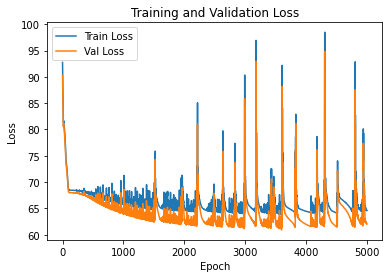

In [52]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [1]:
# Save ground truth and predictions to an Excel file
with torch.no_grad():
    predictions = model(X_val.unsqueeze(1)).numpy()
    df = pd.DataFrame({'GroundTruth': y_val.squeeze().numpy(),
                       'Prediction': predictions.squeeze()})
    df.to_excel('LSTMPermeance1.xlsx', index=True)

NameError: name 'torch' is not defined

In [35]:
# Predict random data from the validation set
random_index = np.random.randint(len(X_val))
random_data = X_val[random_index].reshape(1, 1, -1)  # Reshape to match model input dimensions
model.eval()
with torch.no_grad():
    prediction = model(random_data)
    print("Predicted value:", prediction.item())
    print("Actual value:", y_val[random_index].item())

Predicted value: 2.12837290763855
Actual value: 2.314814805984497


In [37]:
# Save the model state dictionary
torch.save(model.state_dict(), 'models/StateLSTMP1.pth')
# Save the entire model
torch.save(model, 'models/LSTMP1.pth')